Raw data X is (45045, 135)
X_mean is  (45045, 1)
X_cor is  (45045, 135)
X_corvariance is (135, 135)
eigenvectors is (45045, 35)
pca_data (35, 135)


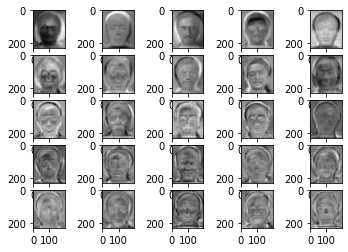

recover shape (45045, 135)


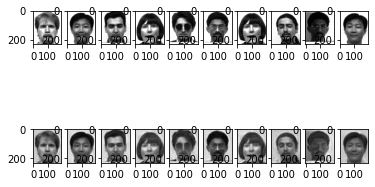

In [35]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist,squareform
#----------------------------------------------------------------
def dataloader(path,H,W):
    pictures = os.listdir(path)
    images = np.zeros((H*W,len(pictures)))
    labels = np.zeros(len(pictures))
    for i,picture in zip(np.arange(len(pictures)),pictures):
        labels[i] = int(picture.split('.')[0][7:9])-1
        image = np.asarray(Image.open(os.path.join(path,picture)).resize((W,H),Image.ANTIALIAS)).flatten()
        images[:,i] = image
    return images , labels
#----------------------------------------------------------------
def pca(X,dim):
    #https://blog.csdn.net/hustqb/article/details/78394058
    #https://blog.csdn.net/zouxy09/article/details/45276053 can know by xT*x get xxT eigenvectors
    X_mean = np.mean(X,axis=1).reshape(-1,1)
    X_cor  = X-X_mean
    print("Raw data X is",X.shape)
    print("X_mean is ",X_mean.shape)
    print("X_cor is ",X_cor.shape)
    X_corvariance  = np.dot(X_cor.T,X_cor)
    print("X_corvariance is",X_corvariance.shape)
    eigenvalues , eigenvectors = np.linalg.eig(X_corvariance)
    sort_index = np.argsort(-eigenvalues)
    sort_index = sort_index[:dim]
    
    eigenvalues = eigenvalues[sort_index]
    eigenvectors = np.dot(X_cor,eigenvectors)
    eigenvectors = eigenvectors[:,sort_index]
    eigenvectors_normalize = np.linalg.norm(eigenvectors,axis=0)
    eigenvectors=eigenvectors/eigenvectors_normalize
    eigenfaces = eigenvectors
    print("eigenvectors is",eigenvectors.shape)  #45045*30
    
    pca_data = np.dot(eigenvectors.T,X_cor)
    print("pca_data",pca_data.shape)
    
    return eigenvalues,eigenfaces,X_mean , pca_data
#----------------------------------------------------------------
def show_eigenfaces(eigenfaces,num,H,W):
    n = int(num**0.5)
    for i in range(num):
        plt.subplot(n,n,i+1)
        plt.imshow(eigenfaces[:,i].reshape(H,W),cmap='gray')
    plt.savefig("eigenfaces.png")
    plt.show()
#----------------------------------------------------------------
def reconstruct(X,X_recover,number,H,W):
    choose = np.random.choice(X.shape[1],number)
    for i in range(number):
        plt.subplot(2,number,i+1)
        plt.imshow(X[:,choose[i]].reshape(H,W),cmap='gray')
        plt.subplot(2,number,i+1+number)
        plt.imshow(X_recover[:,choose[i]].reshape(H,W),cmap='gray')
    plt.savefig("eigenfaces_reconstruct.png")
    plt.show()
#----------------------------------------------------------------

#----------------------------------------------------------------
if __name__ == '__main__':
    filepath = "./Yale_Face_Database/Training"
    H=231
    W=195
    dim = 35
    X_train,y_train = dataloader(filepath,H,W)

    eigenvalues,eigenfaces,X_mean,pca_train = pca(X_train,dim)
    
    #show 25 eigenface
    show_eigenfaces(eigenfaces,25,H,W)
    
    #recover
    recover = np.dot(eigenfaces,pca_train)+X_mean
    print("recover shape",recover.shape)
    number = 10
    reconstruct(X_train,recover,number,H,W)
    



In [36]:
def testing(X_test,y_test,pca_train,y_train,eigenvectors,X_mean,k):
    
    pca_test = np.dot(eigenvectors.T,(X_test-X_mean))
    print("pca_test shape",pca_test.shape)
    
    #k-nn
    test_predict = np.zeros(pca_test.shape[1])
    for i in range(pca_test.shape[1]):
        distance = np.zeros(pca_train.shape[1])
        for j in range(pca_train.shape[1]):
            distance[j] = np.sum(np.square(pca_test[:,i]-pca_train[:,j]))
        sort_index = np.argsort(distance)
        closet_neightbor = y_train[sort_index[:k]]
        unique , counts = np.unique(closet_neightbor,return_counts=True)

        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), key=lambda item: -item[1])]
        test_predict[i] = nearest_neighbors[0]
    accuracy = np.count_nonzero((y_test-test_predict)==0)/len(y_test)    
    return accuracy

if __name__ == '__main__':
    #test and calculate accuracy
    filepath = "./Yale_Face_Database/Testing"
    k=5
    X_test , y_test = dataloader(filepath,H,W)
    accuracy = testing(X_test,y_test,pca_train,y_train,eigenfaces,X_mean,k)
    print("Accuracy is %.3f"%accuracy)

pca_test shape (35, 30)
Accuracy is 0.900


In [144]:
def kernel_trick(x1,gamma):
    print("Commputing RBF kernel")
    ###Compute RBF kernel
    K   = np.exp(-gamma*cdist(x1,x1,'sqeuclidean'))
    ###Compute Polynomial kernel
    K = np.dot(x1,x1.T)+gamma
    K = K**2
    ###Compute linear kernel
    K= np.dot(x1,x1.T)
    
    N   = K.shape[0]
    one_n = np.ones((N,N))/N
    K_hat = K- np.dot(one_n,K) - np.dot(K,one_n)+np.dot(np.dot(one_n,K),one_n)
    print("RBF kernel ready")
    print("RBF shape is ",K.shape)
    return K,K_hat
#----------------------------------------------------------------
def kernel_trick2(x1,x2,gamma):
    ###Compute RBF kernel
    K   = np.exp(-gamma*cdist(x1,x2,'sqeuclidean'))
    ###Compute Polynomial kernel
    K = np.dot(x1,x2.T)+gamma
    K = K**2
    ###Compute linear kernel
    K= np.dot(x1,x2.T)
    return K
#----------------------------------------------------------------
def kernel_pca(kernel,kernel_hat,dim):
    eigenvalues , eigenvectors = np.linalg.eig(kernel_hat)
    sort_index = np.argsort(-eigenvalues)
    sort_index = sort_index[:dim]
    eigenvectors = eigenvectors[:,sort_index]
    eigenvectors_normalize = np.linalg.norm(eigenvectors,axis=0)
    eigenvectors=eigenvectors/eigenvectors_normalize
    
    eigenvalues=np.asarray(eigenvalues.real,dtype='float')
    eigenvectors=np.asarray(eigenvectors.real,dtype='float')
    
    eigenfaces = eigenvectors
    print("kernel shape is ",kernel.shape)
    print("eigenvectors is",eigenvectors.shape)  
    
    pca_data = np.dot(eigenvectors.T,kernel_hat)
    print("pca_data shape is ",pca_data.shape)
    return eigenvectors,pca_data 
#----------------------------------------------------------------
def kernel_testing(X_test,y_test,X_train,training_kernel,eigenvectors,k,gamma):
    test_kernel  = kernel_trick2(X_test.T,X_train.T,gamma)
    print("test_kernel shape is ",test_kernel.shape)  #30*135
    L,N   = test_kernel.shape
    one_N = np.ones((N,N))/N
    one_NL = np.ones((N,L))/N
    test_kernel_hat = test_kernel-np.dot(test_kernel,one_N)
    test_kernel_hat = test_kernel_hat-np.dot(one_NL.T,training_kernel)
    test_kernel_hat = test_kernel_hat+ np.dot(np.dot(one_NL.T,training_kernel),one_N)
    
    
    pca_test = np.dot(eigenvectors.T,test_kernel_hat.T)
    print("pca_test shape",pca_test.shape)
    
    #k-nn
    test_predict = np.zeros(pca_test.shape[1])
    for i in range(pca_test.shape[1]):
        distance = np.zeros(pca_train.shape[1])
        for j in range(pca_train.shape[1]):
            distance[j] = np.sum(np.square(pca_test[:,i]-pca_train[:,j]))
        sort_index = np.argsort(distance)
        closet_neightbor = y_train[sort_index[:k]]
        unique , counts = np.unique(closet_neightbor,return_counts=True)

        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), key=lambda item: -item[1])]
        test_predict[i] = nearest_neighbors[0]
    accuracy = np.count_nonzero((y_test-test_predict)==0)/len(y_test)    
    return accuracy
#----------------------------------------------------------------
if __name__ == '__main__':
    #https://blog.csdn.net/ChenVast/article/details/79236160
    #https://blog.csdn.net/pantingd/article/details/107300037
    #https://zhuanlan.zhihu.com/p/59775730    
    filepath = "./Yale_Face_Database/Training"
    H=231
    W=195
    dim = 20
    gamma = 7e-10
    X_train,y_train = dataloader(filepath,H,W)
    kernel,kernel_hat = kernel_trick(X_train.T,gamma)
    print(kernel)
    eigenvectors,pca_train = kernel_pca(kernel,kernel_hat,dim)
    
    
    #test and calculate accuracy
    filepath = "./Yale_Face_Database/Testing"
    k=5
    X_test , y_test = dataloader(filepath,H,W)
    accuracy = kernel_testing(X_test,y_test,X_train,kernel,eigenvectors,k,gamma)
    print("Accuracy is %.3f"%accuracy)

Commputing RBF kernel
RBF kernel ready
RBF shape is  (135, 135)
[[1.44623548e+09 1.00229435e+09 8.39584633e+08 ... 1.05768203e+09
  1.08581329e+09 1.31682008e+09]
 [1.00229435e+09 9.91207529e+08 5.82540063e+08 ... 1.00395261e+09
  8.10076926e+08 9.43477838e+08]
 [8.39584633e+08 5.82540063e+08 7.13723046e+08 ... 6.37025018e+08
  6.89959110e+08 8.40103013e+08]
 ...
 [1.05768203e+09 1.00395261e+09 6.37025018e+08 ... 1.08769796e+09
  8.70239135e+08 1.01794521e+09]
 [1.08581329e+09 8.10076926e+08 6.89959110e+08 ... 8.70239135e+08
  9.67051078e+08 1.06495951e+09]
 [1.31682008e+09 9.43477838e+08 8.40103013e+08 ... 1.01794521e+09
  1.06495951e+09 1.35611811e+09]]
kernel shape is  (135, 135)
eigenvectors is (135, 20)
pca_data shape is  (20, 135)
test_kernel shape is  (30, 135)
pca_test shape (20, 30)
Accuracy is 0.833
